## NOTE: data now in D:/T5_ClosedLoop/nonstationarities_data/

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR

files = glob.glob('D:/T5_ClosedLoop/*')

In [14]:
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.model_selection import permutation_test_score, KFold
from sklearn.ensemble import BaggingRegressor

from scipy.stats import norm
from scipy.io import savemat, loadmat

cv           = 10
n_bootstraps = 500
random_state = 42
save_dir     = '../data/AcrossSession_PDs/'

n_files = len(files)
n_chans = DataStruct(files[0]).TX.shape[1]


for i, file in enumerate(files):
    save_file = save_dir + file.split('\\')[1].split('.mat')[0] + '.mat'
    
    if not os.path.isfile(save_file):
        dat     = DataStruct(file)
        scores  = np.zeros((n_chans))
        pvals   = np.zeros((n_chans))
        weights = np.zeros((n_chans, n_bootstraps, 3))
        
        for chan in range(n_chans):
            y        = dat.TX[:, chan]
            vel      = dat.targetPos - dat.cursorPos
            lr       = LinearRegression(fit_intercept = True, normalize = False)

            # get mean-fold R^2 and fit p-value:
            scores[chan], _, pvals[chan] = permutation_test_score(lr, vel, y, cv = 10, n_permutations = 500, random_state = random_state, n_jobs = -1)

            # fit bootstrapped estimators to get CIs on weights
            bs_lr               = BaggingRegressor(lr, n_estimators = 500, max_samples = 0.50, bootstrap = True, random_state = random_state, n_jobs = -1)
            bs_lr.fit(vel, y)
            weights[chan, :]    = np.vstack([np.concatenate([[bs_lr.estimators_[k].intercept_], bs_lr.estimators_[k].coef_]) for k in range(n_bootstraps)])
        
        session_data = {'file': file, 'scores' : scores, 'pvals' : pvals, 'weights' : weights}
        savemat(save_file, session_data)
        print('Session completed: ', file)

           

Session completed:  D:/T5_ClosedLoop\t5.2016.09.28.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.03.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.05.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.07.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.10.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.12.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.13.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.17.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.19.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.24.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.26.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.31.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.06.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.08.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.15.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.16.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.19.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.21.mat
Session co

## load single session, plot data

Number of significantly tuned units (uncorrected):  39


Text(0.5, 1.05, 'Distribution of PDs (significant units)')

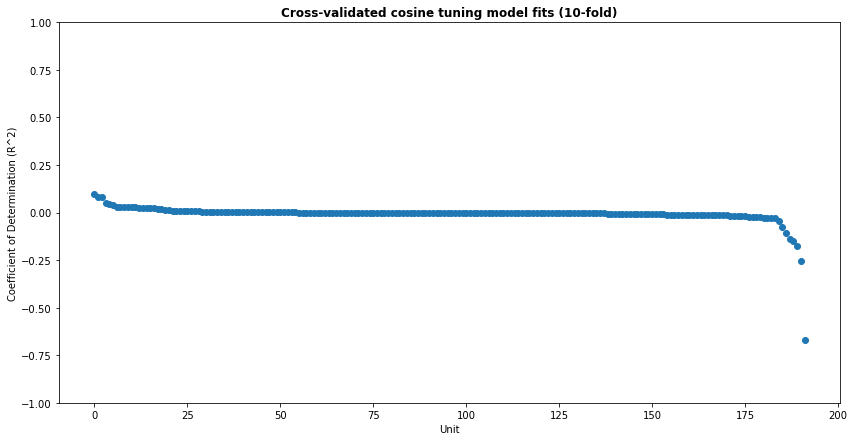

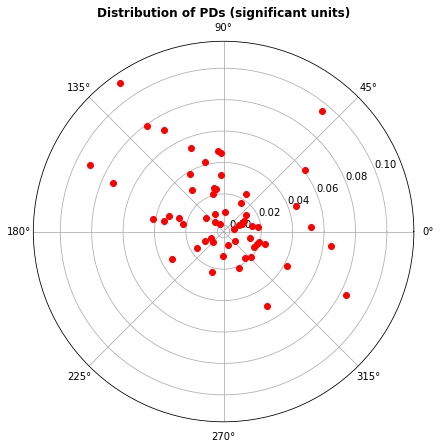

In [163]:
from plotting_utils import figSize
figSize(7, 14)


PD_data   = glob.glob('../data/AcrossSession_PDs/*')
dat       = loadmat(PD_data[0], squeeze_me = True)
scores    = dat['scores']
r1, r2    = dat['weights'][:, :, 1], dat['weights'][:, :, 2] 
reordered = np.argsort(scores)[::-1]

plt.figure(0)
plt.scatter(np.arange(n_chans), scores[reordered])
plt.ylim([-1, 1])
plt.ylabel('Coefficient of Determination (R^2)')
plt.xlabel('Unit')
plt.title('Cross-validated cosine tuning model fits (10-fold)', fontweight = 'bold')
print('Number of significantly tuned units (uncorrected): ', sum(pvals < 0.05))

plt.figure(1)
PDs   = np.arctan2(r2, r1)
theta = np.mean(PDs, axis = 1)
r     = np.mean((r2**2 + r1**2)**0.5, axis = 1)

for i in np.where(dat['pvals'] < 0.05)[0]:
    plt.polar(theta[i], r[i], 'ro')
plt.title('Distribution of PDs (significant units)', fontweight = 'bold')


# across-session trends

In [198]:
files   = glob.glob('../data/AcrossSession_PDs/*')
timelen = len(files)

pvals   = np.zeros((timelen, n_chans))
PDs     = np.zeros((timelen, n_chans, n_bootstraps))
coefs   = np.zeros((timelen, n_chans, n_bootstraps, 3))

for i, file in enumerate(files):
    dat               = loadmat(file)
    pvals[i, :]       = dat['pvals']
    r1, r2            = dat['weights'][:, :, 1], dat['weights'][:, :, 2] 
    coefs[i, :, :, :] = dat['weights']
    PDs[i, :, :]      = np.arctan2(r2, r1)

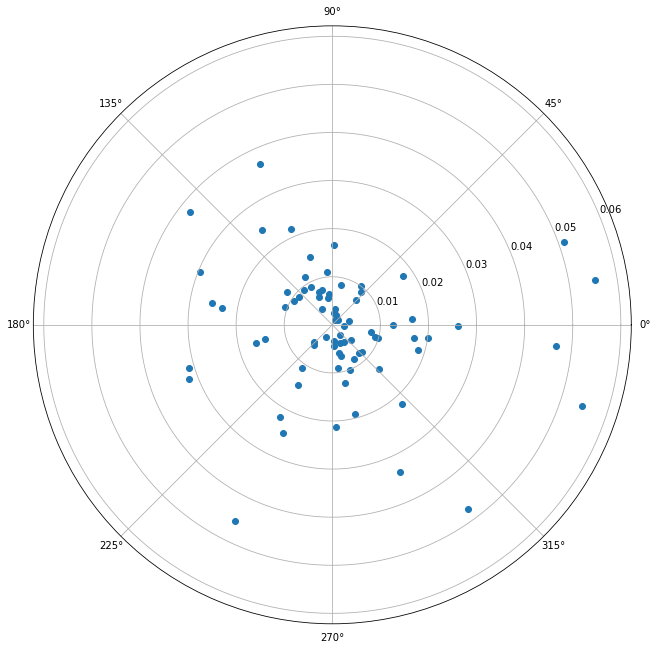

In [343]:
plt.subplot(111, polar = True)
plt.scatter(theta, r)

In [380]:
coefs.shape

(83, 192, 500, 3)

In [384]:
np.mean(coefs[:, ch, :, 0], axis = 1)

array([24.41683932, 36.01403092, 32.48694121, 16.15368514, 26.14852566,
       12.96155768, 16.73669695, 14.01806944,  6.42054576,  4.7392383 ,
        5.20350553,  5.57995922,  8.21668078, 14.63172549,  8.32302093,
        5.77520015,  6.2060224 ,  8.60729899,  5.32892546, 27.92000232,
        7.55099377,  8.11071063,  7.58368173,  9.58931976,  9.66640438,
        6.72275979,  6.17595988,  6.63421617,  6.45827632,  7.6008748 ,
        8.14547169,  7.04221872,  6.81540211,  6.96533738,  6.47938031,
        6.63839843,  6.64484617,  6.52972648,  6.64377045,  7.64785206,
        8.19340184,  6.26794367,  8.18441013,  6.69063863,  6.71806393,
        6.63718749,  7.15704138,  7.31940273,  7.17553948, 10.06204498,
        8.69801299,  6.74654309,  7.99156344,  6.70717857,  6.90417526,
        8.35000231,  7.26058329,  7.41780546,  8.95491349,  6.59982589,
        6.31432798,  7.30217447,  6.6693439 ,  7.4268045 ,  7.28291035,
        7.1191014 ,  9.1940478 ,  8.66127333,  6.88722686,  9.80

Number of channels with significant non-uniformity (uncorrected):  146


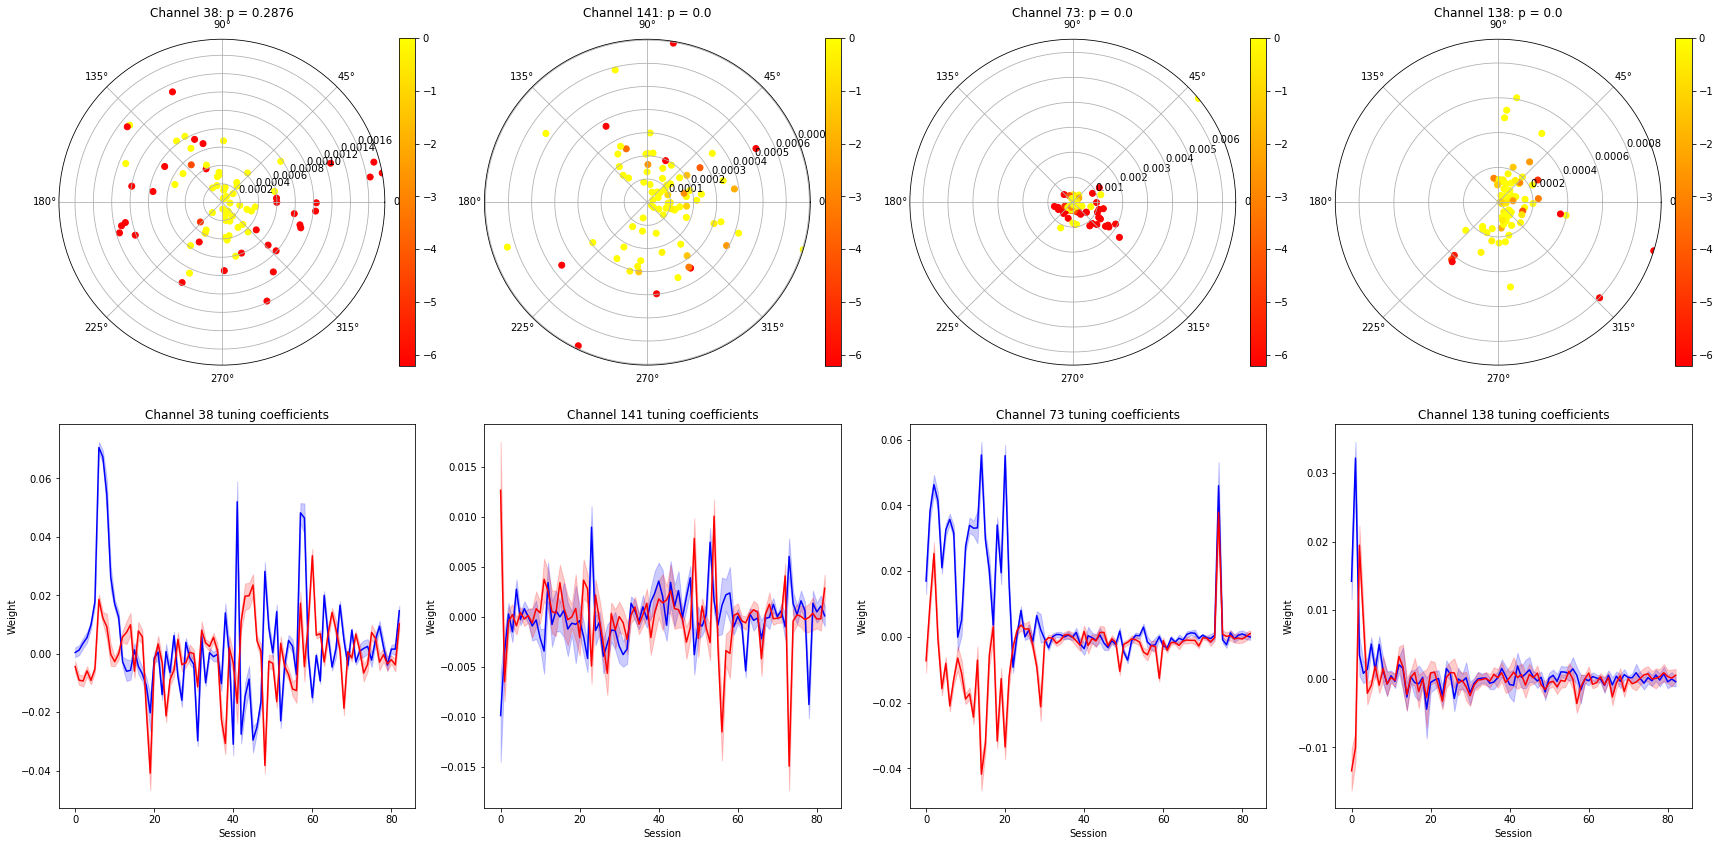

In [389]:
from rayleigh import rayleightest
from matplotlib import colors
import matplotlib.cm as cm

cmap = cm.autumn

figSize(12, 24)

np.random.seed(1)

circ_pvalue = np.zeros((n_chans,))
channels    = np.random.randint(0, n_chans, 4)


for ch in range(n_chans):
    theta = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    circ_pvalue[ch] = rayleightest(theta)


for i, ch in zip(range(1, 5), channels):
    theta      = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    r          = np.linalg.norm(np.mean(coefs[:, ch, :, :], axis = 1)[:, 1:], axis = 1) / np.mean(coefs[:, ch, :, 0], axis = 1)
    
    unit_logp  = np.log(pvals[:, ch])
    vmin, vmax = np.min(unit_logp), np.max(unit_logp)
    norm       = colors.Normalize(vmin = vmin, vmax = vmax)
    
    color      = cmap(norm(unit_logp))

    plt.subplot(2, 4, i, projection='polar')
    im = plt.scatter(theta, r, color = color, cmap = cmap)
    plt.ylim([0, np.max(r)])
    plt.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), fraction=0.046, pad=0.04)
    
    plt.title('Channel ' + str(ch + 1) + ': p = ' + str(np.round(circ_pvalue[ch], 4)))
    
    
    
for i, ch in zip(range(5, 9), channels):
    plt.subplot(2,4,i)
    r1    = coefs[:, ch, :, 1]
    r2    = coefs[:, ch, :, 2]

    #plt.subplot(2, 2, i, projection='polar':
    plotCI(r1.T, color = 'b')
    plotCI(r2.T, color = 'r')
    plt.title('Channel ' + str(ch + 1) + ' tuning coefficients')
    plt.xlabel('Session')
    plt.ylabel('Weight')
    
plt.tight_layout()
print('Number of channels with significant non-uniformity (uncorrected): ', sum(circ_pvalue < 0.05))

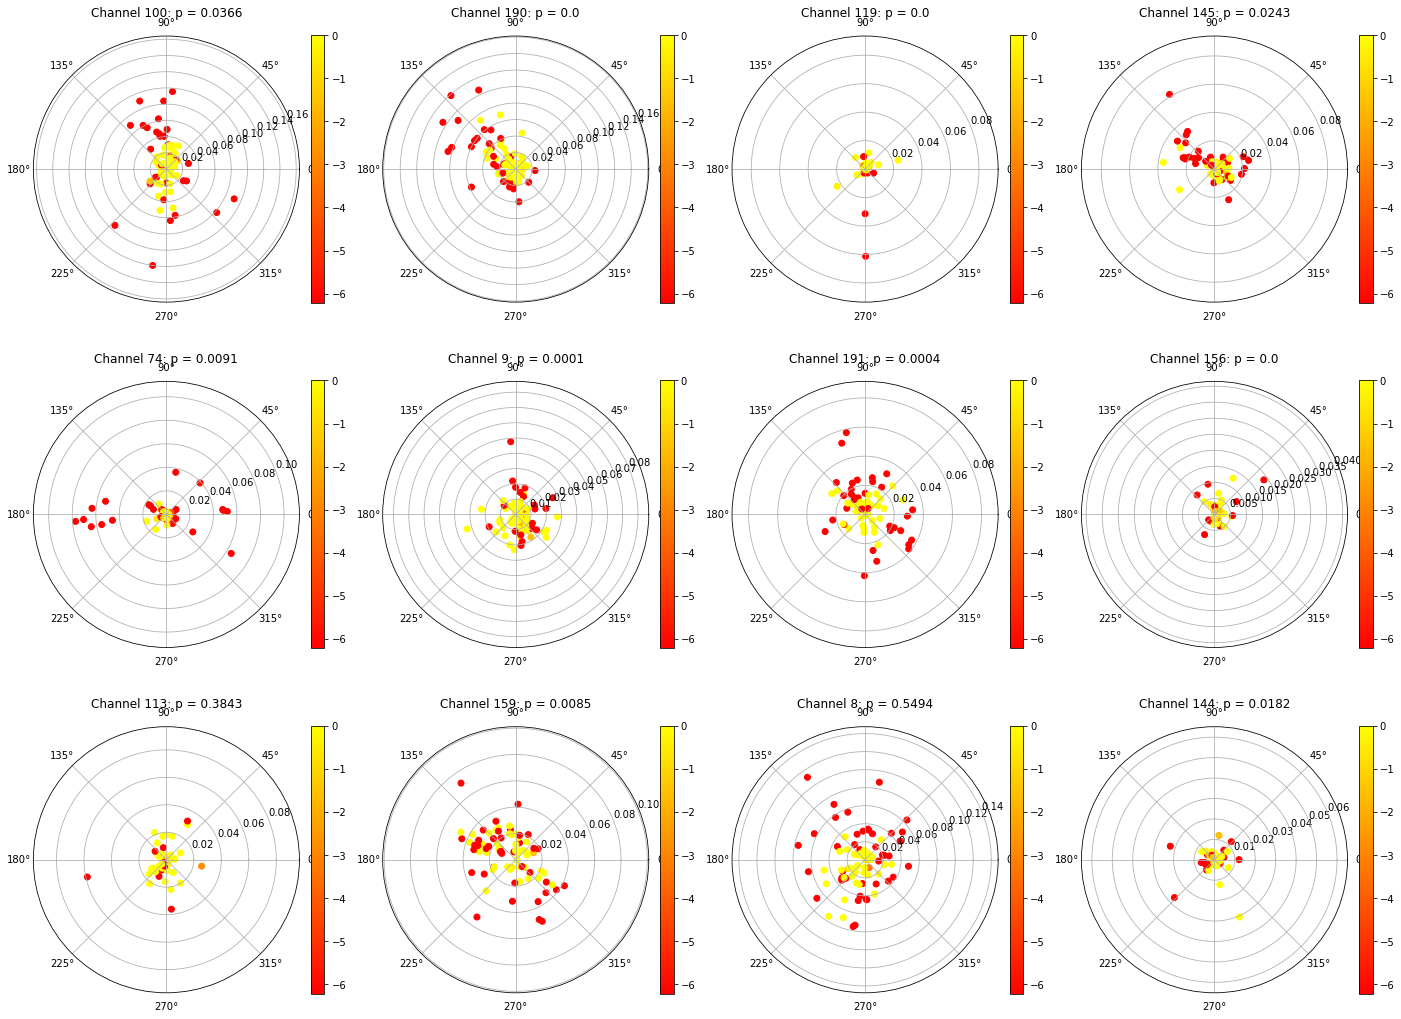

In [379]:
cmap = cm.autumn

figSize(18, 24)

np.random.seed(5)

circ_pvalue = np.zeros((n_chans,))
channels    = np.random.randint(0, n_chans, 13)


for ch in range(n_chans):
    theta = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    r     = np.linalg.norm(np.mean(coefs[:, ch, :, :], axis = 1)[:, 1:], axis = 1)
    circ_pvalue[ch] = rayleightest(theta)


for i, ch in zip(range(1, 13), channels):
    theta      = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    r          = np.linalg.norm(np.mean(coefs[:, ch, :, :], axis = 1)[:, 1:], axis = 1)
    
    unit_logp  = np.log(pvals[:, ch])
    vmin, vmax = np.min(unit_logp), np.max(unit_logp)
    norm       = colors.Normalize(vmin = vmin, vmax = vmax)
    
    color      = cmap(norm(unit_logp))

    plt.subplot(3,4, i, projection='polar')
    im = plt.scatter(theta, r, color = color, cmap = cmap)
    plt.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), fraction=0.046, pad=0.04)
    
    plt.title('Channel ' + str(ch + 1) + ': p = ' + str(np.round(circ_pvalue[ch], 4)))

In [327]:
scores = dat['scores']

In [329]:
pvals.shape

(83, 192)